In [1]:
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

In [2]:
target_sample_rate = 16000
def load_segmented_files(directory):
    wav_files = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, sr = librosa.load(file_path, sr=None)
            wav_files.append(y)
            target_sample_rate = sr
    return wav_files

In [3]:
def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

In [4]:
# 指定 STFT 參數
n_fft = 2048
hop_length = 512
# 指定 
n_mels = 128
mel_spectrograms = []
# 讀取分割後的音訊片段
segmented_files = load_segmented_files('segmented_audio')

100%|██████████| 22506/22506 [00:49<00:00, 453.12it/s]


In [5]:
# 正規化音訊片段
segmented_files = [normalize_audio(audio) for audio in tqdm(segmented_files)]

100%|██████████| 22506/22506 [00:01<00:00, 16632.39it/s]


In [6]:
def convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=target_sample_rate, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

for audio in tqdm(segmented_files):
    mel_spectrogram = convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels)
    mel_spectrograms.append(mel_spectrogram)

100%|██████████| 22506/22506 [01:10<00:00, 319.00it/s]


In [7]:
def plot_mel_spectrogram(mel_spectrogram):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.savefig('mel_spectrogram.png')
    plt.show()

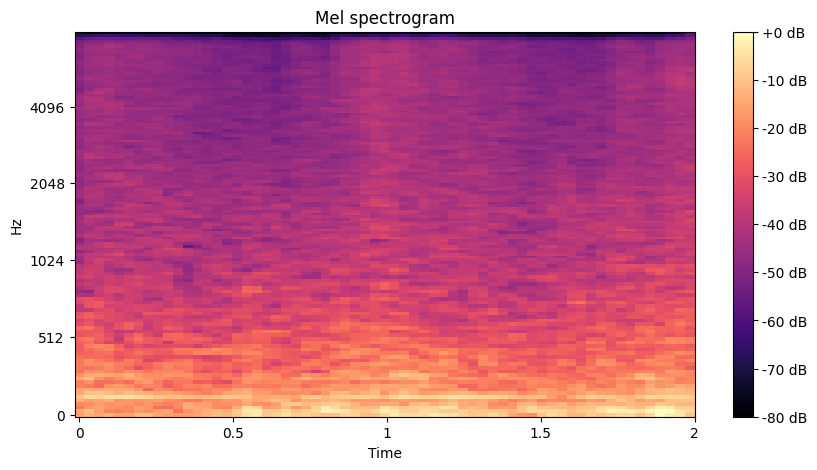

In [8]:
mel_spectrogram_index = 291
mel_spectrogram = mel_spectrograms[mel_spectrogram_index]
plot_mel_spectrogram(mel_spectrogram)

# Spilt Dataset to training and testing

In [9]:
from sklearn.model_selection import train_test_split

# 將梅爾頻譜圖轉換為numpy數組
mel_spectrograms_array = np.array(mel_spectrograms)

# 對數據進行切分
train_data, test_data = train_test_split(mel_spectrograms_array, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (14403, 128, 63)
驗證集數據形狀: (3601, 128, 63)
測試集數據形狀: (4502, 128, 63)


# 調整數據的形狀

In [10]:
# 調整數據的形狀
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], val_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

# 數據歸一化到 [0, 1]
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())
# 打印轉換後的數據形狀
print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (14403, 128, 63, 1)
驗證集數據形狀: (3601, 128, 63, 1)
測試集數據形狀: (4502, 128, 63, 1)


# 創建 CNN Autoencoder 模型

In [11]:
from keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def create_cnn_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    input_height = input_shape[1]
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoded = Lambda(lambda x: x[:, :, :input_height, :])(decoded)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder



# 初始化模型

In [12]:
# 指定輸入形狀
input_shape = np.shape(train_data)[1:]

# 創建 CNN Autoencoder 模型
autoencoder = create_cnn_autoencoder(input_shape)

In [13]:
from tensorflow.keras.optimizers import Adam 
# 設定初始學習率
initial_learning_rate = 0.01

# 創建 Adam 優化器並指定學習率
optimizer = Adam(learning_rate=initial_learning_rate)


# 編譯模型
autoencoder.compile(optimizer='adam', loss='mse')

# 訓練模型

In [14]:
history = autoencoder.fit(train_data, train_data,
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(test_data, test_data))

Epoch 1/100
901/901 [==============================] - 11s 6ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 2/100
901/901 [==============================] - 5s 5ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/100
901/901 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/100
901/901 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/100
901/901 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/100
901/901 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/100
901/901 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/100
901/901 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9/100
901/901 [==============================] - 5s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/100
901/901 [==============================] - 5s 5ms/step - loss: 0.0010 - val_l

# 評估模型

In [15]:
test_loss = autoencoder.evaluate(val_data, val_data)
print("Test loss:", test_loss)

113/113 [==============================] - 1s 4ms/step - loss: 8.6564e-04
Test loss: 0.0008656401187181473


# 繪製訓練過程

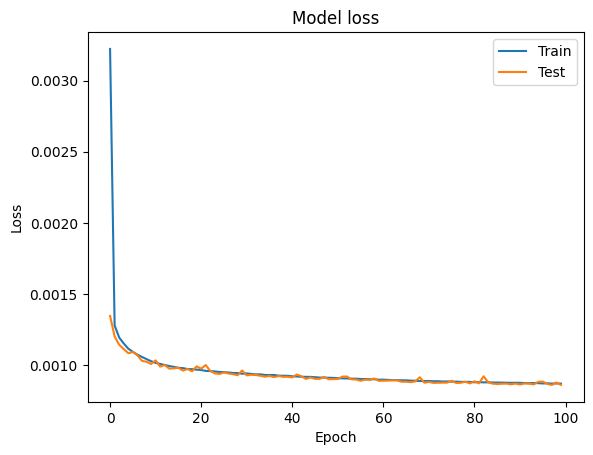

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# 儲存模型

In [17]:
autoencoder.save('mel_autoencoder.h5')

# 使用測試集數據進行預測

In [18]:
reconstructed_data = autoencoder.predict(test_data)

141/141 [==============================] - 1s 4ms/step


In [19]:
def plot_comparison(input_mel_spectrogram, output_mel_spectrogram, input_title, output_title):
    plt.figure(figsize=(20, 5))
    
    # 繪製輸入梅爾頻譜圖
    plt.subplot(1, 2, 1)
    librosa.display.specshow(input_mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(input_title)
    
    # 繪製輸出梅爾頻譜圖
    plt.subplot(1, 2, 2)
    librosa.display.specshow(output_mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(output_title)
    
    plt.tight_layout()
    plt.savefig('reconstructed_mel_spectrogram.png')
    plt.show()

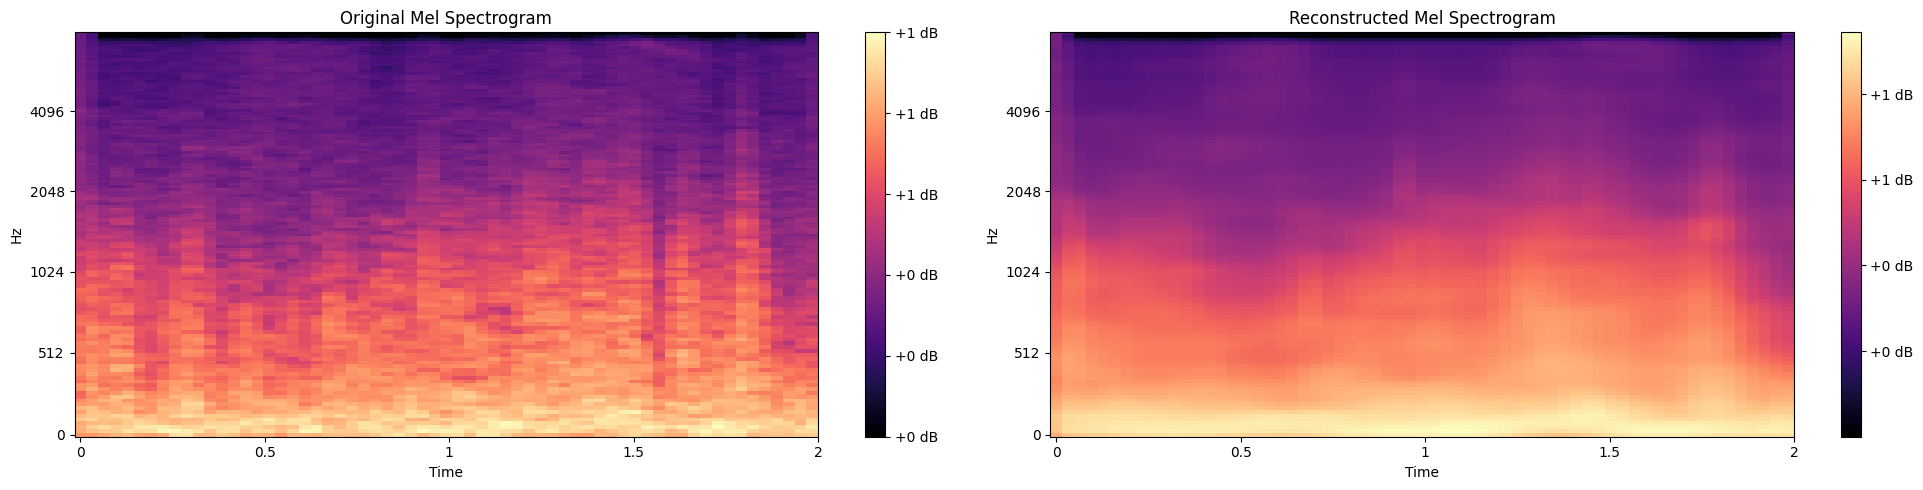

In [20]:
plot_comparison(test_data[0].reshape(test_data[0].shape[0], test_data[0].shape[1]),
                reconstructed_data[0].reshape(reconstructed_data[0].shape[0], reconstructed_data[0].shape[1]),
                'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram')

計算評估指標

In [21]:
# 計算均方誤差 (MSE)
mse = np.mean((test_data - reconstructed_data) ** 2)
print("Reconstruction MSE:", mse)

# 計算平均絕對誤差 (MAE)
mae = np.mean(np.abs(test_data - reconstructed_data))
print("Reconstruction MAE:", mae)

# 計算均方根誤差 (RMSE)
rmse = np.sqrt(np.mean((test_data - reconstructed_data) ** 2))
print("Reconstruction RMSE:", rmse)

Reconstruction MSE: 0.000859584
Reconstruction MAE: 0.021983612
Reconstruction RMSE: 0.029318664
